In [1]:
# %pip install torch
# %pip install wandb
# %pip install pandas
# %pip install numpy
# %pip install sklearn
# %pip install seaborn
# %pip install tensorflow
# %pip install matplotlib
# %pip install transformers
# %pip install torchmetrics
# %pip install pytorch-lightning

In [2]:
import re
import torch
import numpy as np
import pandas as pd
# import seaborn as sns
import pytorch_lightning as pl
import torch.nn.functional as F

from torch import nn
from torch.optim import AdamW
from matplotlib import pyplot as plt
from tensorflow.test import gpu_device_name
from torch.utils.data import Dataset, DataLoader
# from pytorch_lightning.loggers import WandbLogger
# from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy, f1_score, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup

In [3]:
device_name = gpu_device_name()
if device_name:
    print('Found GPU at: {}'.format(device_name))
else:
    print("No GPU found")

No GPU found


In [4]:
MAX_TOKEN_LENGTH = 256
N_EPOCHS = 10
BATCH_SIZE = 12
LABEL_COLUMNS = ['label']

In [5]:
train_df = pd.read_excel("../Scrapper_New/Data_Files/Final/CrimevsNonCrime.xlsx")
print(train_df.describe())
print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")
print(f"Null cells: {train_df.isnull().sum().sum()}")

                                                    Title  Label
count                                               16864  16864
unique                                              16330      2
top     FIFA takes on EA Sports video game in soccer’s...  Crime
freq                                                    4   8641
All entries unique: False
Null cells: 0


In [6]:
train_df.drop_duplicates(subset=['Title'], inplace=True, ignore_index=True, keep='first')
print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")

All entries unique: True


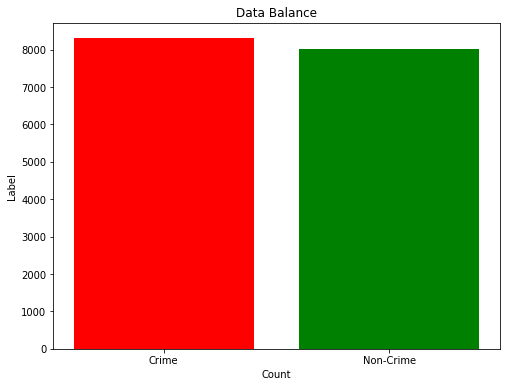

In [7]:
filtered_df = pd.DataFrame(columns=['text', 'label', 'word_count'])

for check_label in LABEL_COLUMNS:
    if check_label not in filtered_df.columns.tolist()[1:]:
        raise Exception("Label names in 'filtered_df' do not match with LABEL_COLUMNS. Check the label columns and add them to LABEL_COLUMNS")

filtered_df['label'] = (pd.Categorical(train_df['Label']).codes).astype(int)
label_counts = train_df['Label'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Data Balance')
plt.show()

Average Word count: 12.005939987752603


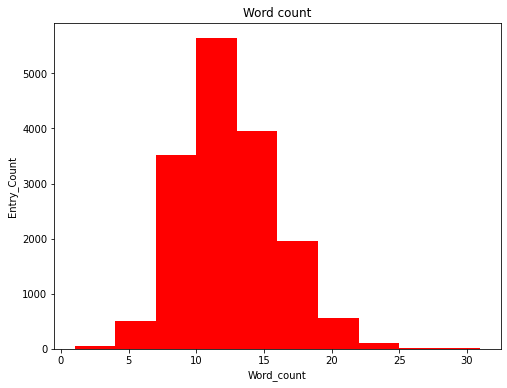

In [8]:
text_list = []
word_count = []

for entry in train_df['Title']:
    new_text = re.sub("[^a-zA-Z ]", " ", entry)
    new_text = new_text.lower().split()
    word_count.append(len(new_text))
    new_text = ' '.join(new_text)
    text_list.append(new_text)

filtered_df['text'] = text_list
filtered_df['word_count'] = word_count

plt.figure(figsize=(8, 6))
print(f'Average Word count: {np.average(word_count)}')
plt.hist(word_count,color='red')
plt.title('Word count')
plt.xlabel('Word_count')
plt.ylabel('Entry_Count')
plt.show()

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Average Token count: 16.729944886711575
Max Token count: 41


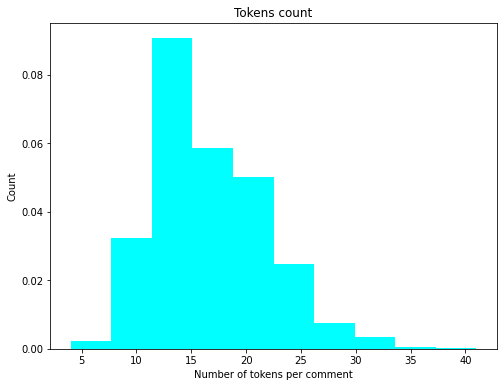

In [10]:
token_counts = []

for _, row in filtered_df.iterrows():

  token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)

plt.figure(figsize=(8, 6))
print(f'Average Token count: {np.average(token_counts)}')
print(f'Max Token count: {max(token_counts)}')
plt.hist(token_counts,color='aqua', density=True)
plt.title('Tokens count')
plt.xlabel('Number of tokens per comment')
plt.ylabel('Count')
plt.show()

In [11]:
class QTagDataset(Dataset):
  def __init__(self, quest, tags, tokenizer, max_token_len = 128):
    self.tokenizer = tokenizer
    self.text = quest
    self.labels = tags
    self.max_len = max_token_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item_idx):
    text = self.text[item_idx]
    inputs = self.tokenizer.encode_plus(
      text,
      None,
      add_special_tokens=True,
      max_length= self.max_len,
      padding = 'max_length',
      return_token_type_ids= False,
      return_attention_mask= True,
      truncation=True,
      return_tensors = 'pt'
      )

    return {
      'input_ids': inputs['input_ids'].flatten(),
      'attention_mask': inputs['attention_mask'].flatten(),
      'label':torch.FloatTensor(self.labels[item_idx])
    }

In [12]:
class QTagDataModule(pl.LightningDataModule):
  def __init__(self,x_tr,y_tr,x_val,y_val,x_test,y_test, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.tr_text = x_tr
    self.tr_label = y_tr
    self.val_text = x_val
    self.val_label = y_val
    self.test_text = x_test
    self.test_label = y_test
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = QTagDataset(quest=self.tr_text,  tags=self.tr_label,tokenizer=self.tokenizer,max_token_len= self.max_token_len)
    self.val_dataset= QTagDataset(quest=self.val_text, tags=self.val_label,tokenizer=self.tokenizer,max_token_len = self.max_token_len)
    self.test_dataset =QTagDataset(quest=self.test_text, tags=self.test_label,tokenizer=self.tokenizer,max_token_len = self.max_token_len)

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle = True , num_workers=8)

  def val_dataloader(self):
    return DataLoader (self.val_dataset, batch_size=self.batch_size, num_workers=8)

  def test_dataloader(self):
    return DataLoader (self.test_dataset, batch_size=self.batch_size, num_workers=8)

In [13]:
class QTagClassifier(pl.LightningModule):

  def __init__(self, n_classes=10, n_training_steps=None, n_warmup_steps=None, lr = 2e-5):
    super().__init__()
    self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCEWithLogitsLoss()
    # self.criterion = nn.BCELoss()
    self.lr = lr

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids=input_ids,attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)

    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=self.lr)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [14]:
x_train_val,x_test,y_train_val,y_test = train_test_split(filtered_df['text'], filtered_df['label'], test_size=0.1,shuffle=True)
x_train,x_val,y_train,y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, shuffle=True)

In [15]:
steps_per_epoch=len(x_train)//BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 5
print(f"Warm Up Steps: {warmup_steps}\nTotal Training Steps: {total_training_steps}")

Warm Up Steps: 1958
Total Training Steps: 9790


In [16]:
data_module = QTagDataModule(x_train,y_train,x_val,y_val,x_test,y_test,tokenizer,batch_size=BATCH_SIZE,max_token_len=MAX_TOKEN_LENGTH)

In [17]:
model = QTagClassifier(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [18]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)
logger = TensorBoardLogger("lightning_logs", name="crime-labels")
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [19]:
trainer = pl.Trainer(
    num_sanity_val_steps=0,
    default_root_dir="./checkpoints/",
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=N_EPOCHS,
    # accelerator='cpu',
    # progress_bar_refresh_rate=30
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [20]:
trainer.fit(model, data_module) 


  | Name       | Type                          | Params
-------------------------------------------------------------
0 | bert       | BertForSequenceClassification | 109 M 
1 | classifier | Linear                        | 769   
2 | criterion  | BCEWithLogitsLoss             | 0     
-------------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.938   Total estimated model params size (MB)


Epoch 0:   0%|          | 0/1225 [00:00<?, ?it/s] 